### Load tensorflow

In [0]:
import tensorflow as tf
#tf.reset_default_graph()
#tf.set_random_seed(42)

In [0]:
#You can download the data manually as well instead of using 'wget'
!wget http://download.tensorflow.org/example_images/flower_photos.tgz --quiet

In [0]:
#Read the dataset
import tarfile
dataset = tarfile.open('flower_photos.tgz')

In [8]:
#Print out all the directories
for name in dataset.getnames():
    tar_member = dataset.getmember(name)
    if(tar_member.isdir()):
         print(name)

flower_photos
flower_photos/roses
flower_photos/sunflowers
flower_photos/tulips
flower_photos/daisy
flower_photos/dandelion


In [0]:
#We will build a pandas dataset
import pandas as pd
df = pd.DataFrame(columns=['class','dir','image_file'])

In [0]:
#Run through tarfile members 
for name in dataset.getnames():
    
    tar_mem = dataset.getmember(name)
    
    #Check if it is a file
    if(tar_mem.isfile() and name.endswith('.jpg')):
        #Build directory and class info
        im_dir = name[0:name.rfind('/')]
        im_class = im_dir[im_dir.rfind('/')+1:]
        #Add record to the dataframe
        df.loc[df.shape[0]] = [im_class, im_dir, name]
        

In [11]:
#Check contents of the dataframe
print('Total images: ', df.shape[0])
df.head()

Total images:  3670


,class,dir,image_file
0,roses,flower_photos/roses,flower_photos/roses/14810868100_87eb739f26_m.jpg
1,roses,flower_photos/roses,flower_photos/roses/1446090416_f0cad5fde4.jpg
2,roses,flower_photos/roses,flower_photos/roses/15319767030_e6c5602a77_m.jpg
3,roses,flower_photos/roses,flower_photos/roses/15032112248_30c5284e54_n.jpg
4,roses,flower_photos/roses,flower_photos/roses/7211616670_2d49ecb3a5_m.jpg


In [12]:
#images by class
print(df.groupby(['class']).size())

class
daisy         633
dandelion     898
roses         641
sunflowers    699
tulips        799
dtype: int64


In [0]:
#extract data
dataset.extractall(path='data/')

In [0]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [0]:
train_df.to_csv('data/flower_photos/train.csv',index=False)
test_df.to_csv('data/flower_photos/test.csv', index=False)

### Read training and test data

In [0]:
import pandas as pd
train_df = pd.read_csv('data/flower_photos/train.csv')
test_df = pd.read_csv('data/flower_photos/test.csv')

In [19]:
#Get class names
class_names = train_df['class'].unique().tolist()
print('Flower classes: ', class_names)

Flower classes:  ['tulips', 'daisy', 'sunflowers', 'dandelion', 'roses']


In [0]:
#Define some parameters
img_size = 224
img_depth = 3  

### Build batch generator

In [0]:
import numpy as np

In [0]:
def batch_generator(df, batchsize=32, train_mode=True):   
    
    img_generator= tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                                                   width_shift_range=0.2,
                                                                   height_shift_range=0.2,
                                                                   horizontal_flip=True)
    
    while True:       
        
        
        #Generate random numbers to pick images from dataset
        batch_nums = np.random.randint(0,df.shape[0],batchsize)
        
        #Initialize batch images array
        batch_images = np.zeros((batchsize,img_size, img_size,img_depth))
        
        #Initiate batch label array
        batch_labels = np.zeros((batchsize, len(class_names)))
        
        for i in range(batchsize):
            
            #Load image
            flower_image =  tf.keras.preprocessing.image.load_img('data/' + 
                                                                  df.loc[batch_nums[i]]['image_file'],
                                                                  target_size=(img_size, img_size))
            #Convert to array
            flower_image = tf.keras.preprocessing.image.img_to_array(flower_image)
            
            if(train_mode):
                #Apply transform
                flower_image =  img_generator.random_transform(flower_image)
            
            
            #Get the class
            img_class = df.loc[batch_nums[i]]['class']
            #Conver class to number
            img_class = class_names.index(img_class)
            #Convert class to one hot encoding
            img_class = tf.keras.utils.to_categorical(img_class, num_classes=len(class_names))
            
            #Update batch images and class arrays
            batch_images[i] = tf.keras.applications.mobilenet.preprocess_input(flower_image)
            batch_labels[i] = img_class
        
        
        yield batch_images, batch_labels          

### Load pre-trained model

In [23]:
model = tf.keras.applications.mobilenet.MobileNet(include_top=False, #Do not include FC layer at the end
                                                  input_shape=(img_size,img_size, img_depth),
                                                  weights='imagenet')

17227776/17225924 [==============================] - 0s 0us/step


In [24]:
model.output

<tf.Tensor 'conv_pw_13_relu/Identity:0' shape=(None, 7, 7, 1024) dtype=float32>

In [0]:
#Set pre-trained model layers to not trainable
for layer in model.layers:
    layer.trainable = False

### Add FC layer for new classes

In [0]:
#get Output layer of Pre0trained model
x = model.output

#Flatten the output to feed to Dense layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)

#Add output layer
prediction = tf.keras.layers.Dense(len(class_names),activation='softmax')(x)

### Building final model for Classification

In [0]:
#Using Keras Model class
final_model = tf.keras.models.Model(inputs=model.input, #Pre-trained model input as input layer
                                    outputs=prediction) #Output layer added

In [0]:
final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
final_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

### Train the model

In [0]:
#Create train and test generator
batchsize = 64
train_generator = batch_generator(train_df, batchsize=batchsize) #batchsize can be changed
test_generator = batch_generator(test_df, batchsize=batchsize, train_mode=False)

In [31]:
final_model.fit_generator(train_generator, 
                          epochs=5,
                          steps_per_epoch= train_df.shape[0]//batchsize,
                          validation_data=test_generator,
                          validation_steps = test_df.shape[0]//batchsize)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
45/45 [==============================] - 45s 1s/step - loss: 0.9314 - accuracy: 0.6514 - val_loss: 0.5627 - val_accuracy: 0.8139
Epoch 2/5
45/45 [==============================] - 45s 1s/step - loss: 0.4982 - accuracy: 0.8285 - val_loss: 0.4884 - val_accuracy: 0.8153
Epoch 3/5
45/45 [==============================] - 45s 1s/step - loss: 0.3703 - accuracy: 0.8753 - val_loss: 0.3604 - val_accuracy: 0.8736
Epoch 4/5
45/45 [==============================] - 45s 996ms/step - loss: 0.3163 - accuracy: 0.8924 - val_loss: 0.3837 - val_accuracy: 0.8807
Epoch 5/5
45/45 [==============================] - 45s 1s/step - loss: 0.3114 - accuracy: 0.8962 - val_loss: 0.3776 - val_accuracy: 0.8622


In [32]:
final_model.fit_generator(train_generator, 
                          epochs=10,
                          steps_per_epoch= train_df.shape[0]//batchsize,
                          validation_data=test_generator,
                          validation_steps = test_df.shape[0]//batchsize, initial_epoch=5)

Epoch 6/10
45/45 [==============================] - 45s 999ms/step - loss: 0.2808 - accuracy: 0.9097 - val_loss: 0.3199 - val_accuracy: 0.9020
Epoch 7/10
45/45 [==============================] - 45s 1000ms/step - loss: 0.2590 - accuracy: 0.9108 - val_loss: 0.3297 - val_accuracy: 0.8679
Epoch 8/10
45/45 [==============================] - 45s 999ms/step - loss: 0.2629 - accuracy: 0.9139 - val_loss: 0.3459 - val_accuracy: 0.8636
Epoch 9/10
45/45 [==============================] - 45s 998ms/step - loss: 0.2427 - accuracy: 0.9201 - val_loss: 0.3629 - val_accuracy: 0.8693
Epoch 10/10
45/45 [==============================] - 45s 1s/step - loss: 0.2369 - accuracy: 0.9201 - val_loss: 0.2909 - val_accuracy: 0.8892


In [33]:
print(len(model.layers))

87


In [34]:
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

### Unfreeze some of Trained Layers in Mobilenet

In [35]:
model.get_layer(index=55).name

'conv_pw_8_relu'

In [0]:
#Unfreezing all layers after layer# 55
for layer in model.layers[56:]:
    layer.trainable =  True    

In [37]:
final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
final_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

In [38]:
final_model.fit_generator(train_generator, 
                          epochs=50,
                          steps_per_epoch= train_df.shape[0]//batchsize,
                          validation_data=test_generator,
                          validation_steps = test_df.shape[0]//batchsize)

Epoch 1/50
45/45 [==============================] - 46s 1s/step - loss: 0.4373 - accuracy: 0.8799 - val_loss: 7.9971 - val_accuracy: 0.4773
Epoch 2/50
45/45 [==============================] - 46s 1s/step - loss: 0.1750 - accuracy: 0.9465 - val_loss: 1.9916 - val_accuracy: 0.7926
Epoch 3/50
45/45 [==============================] - 46s 1s/step - loss: 0.1348 - accuracy: 0.9622 - val_loss: 2.0475 - val_accuracy: 0.7614
Epoch 4/50
45/45 [==============================] - 45s 1s/step - loss: 0.1247 - accuracy: 0.9587 - val_loss: 1.5274 - val_accuracy: 0.7926
Epoch 5/50
45/45 [==============================] - 45s 1s/step - loss: 0.1111 - accuracy: 0.9642 - val_loss: 0.8674 - val_accuracy: 0.8693
Epoch 6/50
45/45 [==============================] - 46s 1s/step - loss: 0.0935 - accuracy: 0.9698 - val_loss: 0.8912 - val_accuracy: 0.9105
Epoch 7/50
45/45 [==============================] - 46s 1s/step - loss: 0.0670 - accuracy: 0.9785 - val_loss: 0.6351 - val_accuracy: 0.9006
Epoch 8/50
45/45 [==

We have achieved an accuracy of 91.76% above. Try unfreezing different number of layers and see if you can improve on the result.

##Prediction

In [39]:
Pred = model.predict_generator(test_generator,test_df.shape[0]//batchsize)

Instructions for updating:
Please use Model.predict, which supports generators.


In [40]:
print(Pred)
print(Pred[0])

[[[[0.         1.607956   0.         ... 0.         6.
    0.        ]
   [0.         3.462516   0.         ... 0.         6.
    0.        ]
   [0.         3.0939922  0.275742   ... 0.         6.
    0.        ]
   ...
   [0.         0.         2.9958377  ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]]

  [[0.         0.5714991  1.2560861  ... 3.8631587  6.
    0.        ]
   [2.0816557  0.         0.         ... 5.287486   6.
    0.        ]
   [0.         0.         1.2501266  ... 2.5619667  3.3902142
    0.        ]
   ...
   [0.         0.         4.679834   ... 1.0693003  0.
    0.        ]
   [0.         0.         2.816169   ... 0.06151763 0.
    0.        ]
   [0.         0.         0.37992075 ... 0.         0.
    0.        ]]

  [[0.         0.         2.8252113  ... 0.         1.6468508
    0.        ]
   [0.         0.         1.0233415  ... 0.  

In [41]:

out=[]
for val in Pred:    
    out.append(np.argmax(val))
print(out)
      
    

[26, 18, 75, 26, 2, 75, 24, 75, 41, 7, 18, 12, 75, 75, 75, 75, 23, 75, 75, 18, 24, 20, 12, 18, 75, 2, 2, 18, 7, 18, 24, 12, 12, 12, 75, 26, 75, 75, 8, 18, 75, 75, 75, 23, 75, 75, 75, 18, 2, 26, 2, 542, 2, 75, 75, 12, 1, 12, 75, 23, 1, 12, 24, 24, 33, 23, 231, 75, 26, 75, 75, 75, 33, 18, 26, 26, 75, 75, 12, 75, 75, 129, 30, 33, 18, 12, 6, 75, 1, 75, 12, 75, 30, 30, 14, 23, 75, 2, 75, 12, 26, 75, 75, 12, 33, 75, 4, 12, 18, 75, 75, 75, 18, 75, 23, 12, 12, 18, 23, 12, 18, 75, 18, 12, 75, 30, 12, 44, 8, 20, 23, 2, 4, 12, 41, 18, 75, 75, 12, 75, 24, 75, 26, 24, 18, 26, 75, 75, 75, 23, 14, 75, 33, 33, 12, 75, 4, 33, 75, 23, 12, 12, 8, 75, 75, 41, 18, 20, 75, 0, 12, 75, 2, 30, 26, 18, 12, 12, 20, 26, 75, 2, 2, 75, 75, 75, 75, 3, 20, 18, 26, 2, 621, 75, 6, 2, 75, 76, 75, 75, 8, 26, 12, 76, 75, 12, 30, 18, 75, 12, 8, 18, 12, 75, 23, 12, 12, 66, 12, 18, 75, 75, 75, 75, 117, 75, 12, 41, 12, 23, 75, 75, 75, 12, 75, 12, 75, 75, 12, 23, 75, 75, 75, 75, 75, 75, 26, 1, 24, 23, 230, 2, 75, 75, 23, 1, 12

label for each of the below image: 26
label for each of the below image: 18
label for each of the below image: 75
label for each of the below image: 26
label for each of the below image: 2
label for each of the below image: 75
label for each of the below image: 24
label for each of the below image: 75
label for each of the below image: 41
label for each of the below image: 7


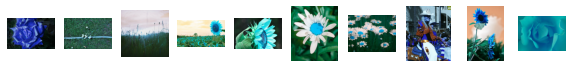

In [42]:
import numpy as np
# visualizing the first 10 images in the dataset and their labels
%matplotlib inline
import matplotlib.pyplot as plt
import cv2 as cv
plt.figure(figsize=(10, 1))
for i in range(10):
  plt.subplot(1, 10, i+1)
  img = cv.imread('data/' + test_df.loc[i]['image_file'])
  plt.imshow(img, cmap="gray")
  plt.axis('off')
  print('label for each of the below image: %s' % (out[i]))
plt.show()